## Prediction of Glocuse Concetrations using midIR Absorbance Spectra and RandomForest Regressor



### Summary:

A dataset of spectra abosrbance in the midIR range with known glucose concentrations will be used to train a predictive model. The dataset contains glucose concentrations ranging from 80 to 195 mg/dl. Each concentration contains 80 repeated measurements of broad spectrum absorbance in the 950 to 1200 cm^-1 wavenumber range at 1 cm^-1 resolution.

RandomForestRegressor will be used for initial model training. The random forest built-in feature importance calculations, along with feature permutation importance calculations, will be used to identify the most important absorbance region/s for determining glucose concentrations and the laser's optimal wavenumber width.

Finally, the ability of the absorbance spectra provided to be used to predict glucose concentrations in phantom skin models will be discussed.



## Outline:


#### Task 1: Perform predictive modeling and predict glucose concentrations from solution absorbance spectra. Performance is reported in terms of Mean Absolute Relative Difference (MARD).


1.1 Loading and describing the datasets.

1.2 Transforming the data

1.2.1 Scaling Data: MinMaxScaler

1.2.2 Averaging every three wavenumbers for initial parameter screen

1.3 Screen parameters using GridSearchCV

1.4 Using best parameters to model on the original dataset (wavenumbers are not averaged)




#### Task 2: When lasers are manufactured, the trade-off between the number of wavenumbers they span and their cost must be considered. Does the predictive performance change with the number of wavenumbers available? What is the minimum number you would recommend?

2.1 Feature importance using the averaged dataset (every three wavenumbers):

2.1.1 RandomForest Feature Importance

2.1.2 Feature Permutations

2.2 Select most important regions / wavenumbers for glucose concentration predictions

2.3 Create predictive model using the most important wavenumber of each region and compare between results

2.4 Create predictive model through increasing laser width to determine best configuration



#### Task 3: Evaluating the ability of the device to capture glucose information on a new type of skin model in the lab.

3.1 Display absorbance spectra of the 5 phantom concentrations

3.2 Display relative and scaled absorbance spectra

3.3 Discuss findings and recommendations

3.4 Predicting phantom glucose concentrations based on model trained using free solution data - Not ideal.




In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import get_cmap
from matplotlib.colors import ListedColormap
from collections import Counter
from sklearn.model_selection import train_test_split,KFold, cross_val_score,GridSearchCV
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from scipy.stats import ttest_ind, chi2_contingency, ks_2samp
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer
from sklearn.decomposition import PCA
from itertools import combinations
from scipy import stats
from copy import deepcopy
import warnings
import time
from google.colab import drive
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
!fusermount -u /content/drive
drive.mount('/content/drive')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)

## Task 1: Glucose Concentration Predictive Modeling in Free Solution

In [2]:
start_time = time.time()
data = pd.read_csv('/content/drive/MyDrive/20250116--coding-challenge-data/yaniv.csv')
df1 = pd.read_json('/content/drive/MyDrive/glucose/dataset_1.json')
df2 = pd.read_json('/content/drive/MyDrive/glucose/dataset_2.json')
glucose = pd.read_json('/content/drive/MyDrive/glucose/glucose.json')

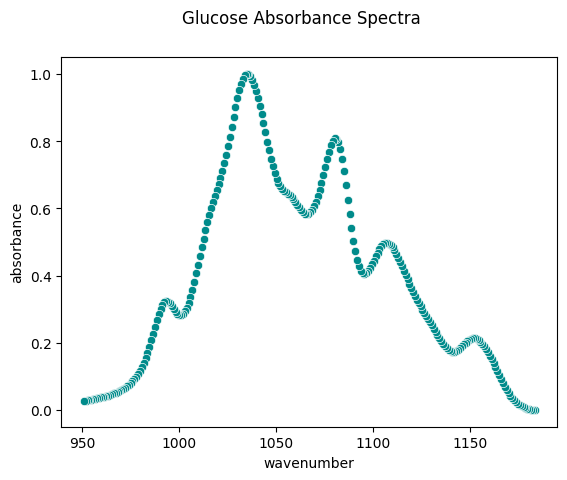

In [3]:
sns.scatterplot(glucose,y='absorbance',x='wavenumber',color='darkcyan')
plt.suptitle('Glucose Absorbance Spectra')
plt.show()

The glucose absorbance spectra shows 5 distinct regions with local maximum absorbance, and the region at 1020-1040 [cm^-1] showing the global maximum absorbance.

In [4]:
df1.head()

,wavenumber,absorbance,glucose
0,"[950.0, 951.0, 952.0, 953.0, 954.0, 955.0, 956...","[0.0054450321, 0.0050841617, 0.0047476634, 0.0...",180
1,"[950.0, 951.0, 952.0, 953.0, 954.0, 955.0, 956...","[0.0051177328, 0.004855426, 0.0046091433, 0.00...",160
2,"[950.0, 951.0, 952.0, 953.0, 954.0, 955.0, 956...","[0.0018736758, 0.0021172502000000003, 0.002357...",90
3,"[950.0, 951.0, 952.0, 953.0, 954.0, 955.0, 956...","[0.0019114823, 0.001861196, 0.0018255961000000...",90
4,"[950.0, 951.0, 952.0, 953.0, 954.0, 955.0, 956...","[0.0034135354000000002, 0.0034606581, 0.003512...",110


Text(0, 0.5, 'Count')

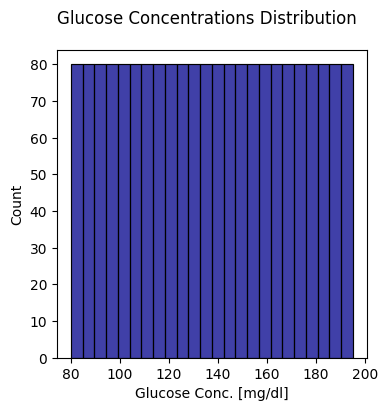

In [5]:
plt.figure(figsize=(4,4))
sns.histplot(df1['glucose'],bins=24,color='darkblue')
plt.suptitle('Glucose Concentrations Distribution')
plt.xlabel('Glucose Conc. [mg/dl]')
plt.ylabel('Count')

Glucose concentrations range from 80 to 195 [mg/dl]. All glucose concentrations are equally represented in the dataset, 80 samples per concentration.

In [6]:
y = df1['glucose']  #target variable
df1 = pd.DataFrame(
    df1["absorbance"].to_list(),
    columns=df1["wavenumber"][0]  # Use the first row of wavenumbers as columns
)

In [7]:
df1.head()

,950.0,951.0,952.0,953.0,954.0,955.0,956.0,957.0,958.0,959.0,960.0,961.0,962.0,963.0,964.0,965.0,966.0,967.0,968.0,969.0,970.0,971.0,972.0,973.0,974.0,975.0,976.0,977.0,978.0,979.0,980.0,981.0,982.0,983.0,984.0,985.0,986.0,987.0,988.0,989.0,990.0,991.0,992.0,993.0,994.0,995.0,996.0,997.0,998.0,999.0,1000.0,1001.0,1002.0,1003.0,1004.0,1005.0,1006.0,1007.0,1008.0,1009.0,1010.0,1011.0,1012.0,1013.0,1014.0,1015.0,1016.0,1017.0,1018.0,1019.0,1020.0,1021.0,1022.0,1023.0,1024.0,1025.0,1026.0,1027.0,1028.0,1029.0,1030.0,1031.0,1032.0,1033.0,1034.0,1035.0,1036.0,1037.0,1038.0,1039.0,1040.0,1041.0,1042.0,1043.0,1044.0,1045.0,1046.0,1047.0,1048.0,1049.0,1050.0,1051.0,1052.0,1053.0,1054.0,1055.0,1056.0,1057.0,1058.0,1059.0,1060.0,1061.0,1062.0,1063.0,1064.0,1065.0,1066.0,1067.0,1068.0,1069.0,1070.0,1071.0,1072.0,1073.0,1074.0,1075.0,1076.0,1077.0,1078.0,1079.0,1080.0,1081.0,1082.0,1083.0,1084.0,1085.0,1086.0,1087.0,1088.0,1089.0,1090.0,1091.0,1092.0,1093.0,1094.0,1095.0,1096.0,1097.0,1098.0,1099.0,1100.0,1101.0,1102.0,1103.0,1104.0,1105.0,1106.0,1107.0,1108.0,1109.0,1110.0,1111.0,1112.0,1113.0,1114.0,1115.0,1116.0,1117.0,1118.0,1119.0,1120.0,1121.0,1122.0,1123.0,1124.0,1125.0,1126.0,1127.0,1128.0,1129.0,1130.0,1131.0,1132.0,1133.0,1134.0,1135.0,1136.0,1137.0,1138.0,1139.0,1140.0,1141.0,1142.0,1143.0,1144.0,1145.0,1146.0,1147.0,1148.0,1149.0,1150.0,1151.0,1152.0,1153.0,1154.0,1155.0,1156.0,1157.0,1158.0,1159.0,1160.0,1161.0,1162.0,1163.0,1164.0,1165.0,1166.0,1167.0,1168.0,1169.0,1170.0,1171.0,1172.0,1173.0,1174.0,1175.0,1176.0,1177.0,1178.0,1179.0,1180.0,1181.0,1182.0,1183.0,1184.0,1185.0,1186.0,1187.0,1188.0,1189.0,1190.0,1191.0,1192.0,1193.0,1194.0,1195.0,1196.0,1197.0,1198.0,1199.0,1200.0
0,0.005445,0.005084,0.004748,0.004435,0.004140,0.003857,0.003587,0.003337,0.003115,0.002924,0.002761,0.002618,0.002489,0.002373,0.002277,0.002208,0.002167,0.002151,0.002153,0.002166,0.002187,0.002212,0.002242,0.002275,0.002312,0.002354,0.002403,0.002459,0.002518,0.002580,0.002642,0.002705,0.002771,0.002840,0.002912,0.002984,0.003054,0.003120,0.003180,0.003235,0.003282,0.003315,0.003332,0.003330,0.003312,0.003279,0.003239,0.003197,0.003157,0.003123,0.003097,0.003078,0.003066,0.003063,0.003072,0.003093,0.003128,0.003174,0.003231,0.003296,0.003367,0.003443,0.003522,0.003604,0.003688,0.003772,0.003851,0.003922,0.003983,0.004035,0.004084,0.004136,0.004193,0.004256,0.004324,0.004396,0.004475,0.004560,0.004647,0.004732,0.004807,0.004867,0.004909,0.004935,0.004950,0.004957,0.004960,0.004959,0.004954,0.004943,0.004928,0.004913,0.004899,0.004888,0.004881,0.004876,0.004873,0.004873,0.004876,0.004883,0.004892,0.004901,0.004908,0.004914,0.004918,0.004918,0.004913,0.004904,0.004893,0.004879,0.004865,0.004853,0.004846,0.004850,0.004866,0.004893,0.004926,0.004961,0.004996,0.005033,0.005079,0.005140,0.005220,0.005317,0.005426,0.005541,0.005657,0.005769,0.005873,0.005966,0.006038,0.006083,0.006093,0.006071,0.006023,0.005960,0.005889,0.005818,0.005750,0.005690,0.005647,0.005626,0.005630,0.005656,0.005697,0.005747,0.005805,0.005870,0.005945,0.006030,0.006124,0.006224,0.006324,0.006420,0.006505,0.006574,0.006625,0.006659,0.006680,0.006691,0.006696,0.006692,0.006680,0.006661,0.006637,0.006608,0.006571,0.006526,0.006473,0.006418,0.006366,0.006323,0.006292,0.006271,0.006256,0.006242,0.006226,0.006203,0.006170,0.006124,0.006065,0.005992,0.005906,0.005812,0.005713,0.005618,0.005531,0.005459,0.005407,0.005378,0.005371,0.005382,0.005405,0.005435,0.005473,0.005520,0.005579,0.005650,0.005728,0.005808,0.005880,0.005940,0.005984,0.006012,0.006027,0.006033,0.006031,0.006023,0.006010,0.005992,0.005972,0.005952,0.005933,0.005917,0.005903,0.005890,0.005877,0.005865,0.005851,0.005833,0.005803,0.005755,0.005682,0.005581,0.005451,0.005296,0.005122,0.004939,0.004755,0.004579,0.004417,0.004272,0.004146,0.004041,0.003960,0.003960,0.003960,0.003960,0.003960,0.003960,0.003960,0.003960,0.003960,0.003960,0.003960,0.003960,0.003960,0.003960,0.003960,0.003960,0.003960
1,0.005118,0.004855,0.004609,0.

Scaling df1 dataset using MinMaxScaler

In [8]:
# Scaling the dataset using MinMaxScaler
scaler = MinMaxScaler()
df1 = pd.DataFrame(scaler.fit_transform(df1), columns=df1.columns)

In [9]:
df1.head()

,950.0,951.0,952.0,953.0,954.0,955.0,956.0,957.0,958.0,959.0,960.0,961.0,962.0,963.0,964.0,965.0,966.0,967.0,968.0,969.0,970.0,971.0,972.0,973.0,974.0,975.0,976.0,977.0,978.0,979.0,980.0,981.0,982.0,983.0,984.0,985.0,986.0,987.0,988.0,989.0,990.0,991.0,992.0,993.0,994.0,995.0,996.0,997.0,998.0,999.0,1000.0,1001.0,1002.0,1003.0,1004.0,1005.0,1006.0,1007.0,1008.0,1009.0,1010.0,1011.0,1012.0,1013.0,1014.0,1015.0,1016.0,1017.0,1018.0,1019.0,1020.0,1021.0,1022.0,1023.0,1024.0,1025.0,1026.0,1027.0,1028.0,1029.0,1030.0,1031.0,1032.0,1033.0,1034.0,1035.0,1036.0,1037.0,1038.0,1039.0,1040.0,1041.0,1042.0,1043.0,1044.0,1045.0,1046.0,1047.0,1048.0,1049.0,1050.0,1051.0,1052.0,1053.0,1054.0,1055.0,1056.0,1057.0,1058.0,1059.0,1060.0,1061.0,1062.0,1063.0,1064.0,1065.0,1066.0,1067.0,1068.0,1069.0,1070.0,1071.0,1072.0,1073.0,1074.0,1075.0,1076.0,1077.0,1078.0,1079.0,1080.0,1081.0,1082.0,1083.0,1084.0,1085.0,1086.0,1087.0,1088.0,1089.0,1090.0,1091.0,1092.0,1093.0,1094.0,1095.0,1096.0,1097.0,1098.0,1099.0,1100.0,1101.0,1102.0,1103.0,1104.0,1105.0,1106.0,1107.0,1108.0,1109.0,1110.0,1111.0,1112.0,1113.0,1114.0,1115.0,1116.0,1117.0,1118.0,1119.0,1120.0,1121.0,1122.0,1123.0,1124.0,1125.0,1126.0,1127.0,1128.0,1129.0,1130.0,1131.0,1132.0,1133.0,1134.0,1135.0,1136.0,1137.0,1138.0,1139.0,1140.0,1141.0,1142.0,1143.0,1144.0,1145.0,1146.0,1147.0,1148.0,1149.0,1150.0,1151.0,1152.0,1153.0,1154.0,1155.0,1156.0,1157.0,1158.0,1159.0,1160.0,1161.0,1162.0,1163.0,1164.0,1165.0,1166.0,1167.0,1168.0,1169.0,1170.0,1171.0,1172.0,1173.0,1174.0,1175.0,1176.0,1177.0,1178.0,1179.0,1180.0,1181.0,1182.0,1183.0,1184.0,1185.0,1186.0,1187.0,1188.0,1189.0,1190.0,1191.0,1192.0,1193.0,1194.0,1195.0,1196.0,1197.0,1198.0,1199.0,1200.0
0,0.663631,0.644785,0.624648,0.603957,0.584195,0.553085,0.511368,0.469002,0.426500,0.387164,0.352665,0.322143,0.298045,0.276124,0.258909,0.245520,0.235330,0.229543,0.226357,0.224472,0.223572,0.222449,0.221040,0.221782,0.234108,0.247577,0.261071,0.274176,0.286973,0.299681,0.312301,0.324476,0.335689,0.345607,0.354205,0.358320,0.370034,0.382451,0.391384,0.395081,0.397409,0.398307,0.397759,0.395824,0.392672,0.388602,0.383974,0.379092,0.374129,0.370335,0.373872,0.377572,0.379488,0.379479,0.375471,0.372723,0.371419,0.371605,0.374365,0.379906,0.386231,0.395241,0.400643,0.405541,0.409822,0.413463,0.416611,0.419521,0.422403,0.425323,0.428196,0.430891,0.432198,0.435129,0.438831,0.442072,0.441103,0.439768,0.438041,0.435873,0.433210,0.430003,0.426220,0.421873,0.417017,0.411755,0.408167,0.408525,0.408953,0.409463,0.410094,0.410903,0.411969,0.412325,0.407221,0.400769,0.395365,0.391202,0.388215,0.382342,0.379913,0.380174,0.381507,0.384690,0.391065,0.398133,0.405658,0.413596,0.421916,0.430570,0.439517,0.447126,0.448312,0.449602,0.451061,0.452539,0.453062,0.451458,0.448143,0.444393,0.440294,0.435949,0.431472,0.426954,0.430534,0.435809,0.441127,0.446505,0.451899,0.457209,0.462325,0.467174,0.471733,0.472533,0.468654,0.464886,0.461442,0.458581,0.456571,0.455650,0.454972,0.452572,0.452918,0.451989,0.454184,0.458156,0.463343,0.469193,0.475603,0.482469,0.489665,0.497037,0.504439,0.513650,0.522620,0.530787,0.529387,0.527449,0.524823,0.521403,0.518759,0.517223,0.515186,0.512775,0.510130,0.507378,0.504614,0.501913,0.504610,0.509423,0.514591,0.520209,0.525119,0.525665,0.526755,0.523538,0.519707,0.516610,0.514246,0.512600,0.511669,0.511473,0.512051,0.513454,0.515734,0.512860,0.508257,0.507029,0.505738,0.504283,0.502717,0.501070,0.503241,0.505583,0.507804,0.509775,0.511406,0.512621,0.513326,0.513408,0.511266,0.504299,0.496947,0.489944,0.483205,0.476083,0.468527,0.461010,0.454316,0.446635,0.437953,0.429409,0.423449,0.416806,0.409541,0.401705,0.393328,0.386429,0.379846,0.365824,0.351453,0.338008,0.325369,0.313286,0.301486,0.289867,0.278601,0.268026,0.258435,0.249942,0.242535,0.236156,0.230701,0.225957,0.221634,0.221634,0.221634,0.221634,0.221634,0.221634,0.221634,0.221634,0.221634,0.221634,0.221634,0.221634,0.221634,0.221634,0.221634,0.221634,0.221634
1,0.626793,0.617085,0.606505,0.

The individual wavenumbers will be used as features to train a RandomForestRegressor. For the initial hyperparameter screen I choose to average every 3 consecutive wavenumber's absorbance. This will reduce the number of potential feature for training the model and make the screening process quicker. Later, the top tuned hyperparameter combinations will be used to train a model based on all the wavenumbers.

Averaged_df1 is the dataset with every three wavenumbers have their absorbance averages


In [10]:
# Compute the average of every 3 columns
averaged_df1 = df1.iloc[:, :-2].groupby(np.arange(len(df1.columns[:-2])) // 3, axis=1).mean()

# Calculate the new column names as the average wavenumber values
averaged_df1.columns = np.array(df1.columns[:-2]).reshape(-1, 3).mean(axis=1).reshape(-1)

# Display the new DataFrame
averaged_df1.head()

,951.0,954.0,957.0,960.0,963.0,966.0,969.0,972.0,975.0,978.0,981.0,984.0,987.0,990.0,993.0,996.0,999.0,1002.0,1005.0,1008.0,1011.0,1014.0,1017.0,1020.0,1023.0,1026.0,1029.0,1032.0,1035.0,1038.0,1041.0,1044.0,1047.0,1050.0,1053.0,1056.0,1059.0,1062.0,1065.0,1068.0,1071.0,1074.0,1077.0,1080.0,1083.0,1086.0,1089.0,1092.0,1095.0,1098.0,1101.0,1104.0,1107.0,1110.0,1113.0,1116.0,1119.0,1122.0,1125.0,1128.0,1131.0,1134.0,1137.0,1140.0,1143.0,1146.0,1149.0,1152.0,1155.0,1158.0,1161.0,1164.0,1167.0,1170.0,1173.0,1176.0,1179.0,1182.0,1185.0,1188.0,1191.0,1194.0,1197.0
0,0.644355,0.580412,0.468957,0.353991,0.277693,0.236798,0.224801,0.221757,0.247585,0.286943,0.324155,0.352711,0.381290,0.396932,0.395418,0.383890,0.372779,0.378846,0.373204,0.375292,0.394038,0.409609,0.419512,0.428137,0.435386,0.440981,0.435708,0.426032,0.412313,0.408980,0.410989,0.406772,0.391594,0.380810,0.385754,0.405795,0.430668,0.448347,0.452220,0.447998,0.435905,0.431099,0.446510,0.462236,0.470974,0.461636,0.455731,0.452493,0.458561,0.475755,0.497047,0.522353,0.527220,0.519128,0.512697,0.504635,0.509541,0.523664,0.523333,0.514486,0.511731,0.514016,0.507008,0.502690,0.505543,0.511267,0.512666,0.497063,0.475938,0.453987,0.430270,0.409351,0.386535,0.351761,0.313380,0.278831,0.250304,0.230938,0.221634,0.221634,0.221634,0.221634,0.221634
1,0.616794,0.583570,0.507855,0.432151,0.386232,0.363866,0.374313,0.398245,0.442587,0.497286,0.546585,0.586209,0.608966,0.602159,0.582875,0.557159,0.530275,0.520198,0.499920,0.493801,0.509800,0.524475,0.541596,0.559994,0.575930,0.580464,0.563152,0.542461,0.520874,0.507630,0.499990,0.485683,0.457058,0.430494,0.418928,0.424222,0.437664,0.448097,0.449649,0.447740,0.441572,0.444802,0.468349,0.491337,0.506141,0.499442,0.489994,0.473185,0.457219,0.449681,0.449840,0.462947,0.466603,0.469011,0.485030,0.507242,0.544973,0.589232,0.610731,0.610551,0.605859,0.595408,0.560863,0.519430,0.483423,0.454127,0.429340,0.402751,0.387127,0.387606,0.403637,0.437707,0.479508,0.506136,0.521595,0.538795,0.555582,0.569320,0.576733,0.576733,0.576733,0.576733,0.576733
2,0.286264,0.376803,0.470354,0.584425,0.689336,0.726169,0.744814,0.732727,0.700975,0.666915,0.630396,0.585548,0.526949,0.465100,0.408825,0.371751,0.367132,0.389542,0.400185,0.425380,0.469881,0.503705,0.526556,0.549840,0.566715,0.565893,0.549285,0.529732,0.508683,0.507453,0.517244,0.519629,0.507646,0.497683,0.494194,0.498565,0.509135,0.517575,0.519257,0.516681,0.500621,0.488742,0.496326,0.515974,0.541575,0.556917,0.579172,0.593084,0.596751,0.602467,0.614863,0.637117,0.632787,0.617630,0.615572,0.622119,0.644667,0.672426,0.678181,0.674577,0.675596,0.677723,0.663676,0.652623,0.645714,0.644236,0.648389,0.648174,0.657389,0.682346,0.721684,0.773732,0.829917,0.848843,0.845917,0.844456,0.843881,0.843721,0.843696,0.843696,0.843696,0.843696,0.843696
3,0.254112,0.219159,0.171238,0.135135,0.148525,0.180813,0.215107,0.244650,0.285959,0.330815,0.366624,0.393601,0.422198,0.437569,0.445580,0.448174,0.441706,0.441080,0.415124,0.380758,0.353947,0.328252,0.303026,0.277623,0.252548,0.237496,0.223965,0.212295,0.202945,0.211960,0.227745,0.237183,0.233732,0.225266,0.224376,0.232049,0.239594,0.240530,0.231541,0.216610,0.197165,0.189876,0.212686,0.239151,0.266133,0.285466,0.301896,0.308997,0.312295,0.310684,0.301160,0.292932,0.273150,0.246370,0.227419,0.208816,0.211166,0.228468,0.239626,0.248003,0.259735,0.274961,0.289124,0.307451,0.330731,0.353565,0.369017,0.368195,0.361328,0.352068,0.338754,0.325317,0.304850,0.272780,0.237056,0.206075,0.180388,0.161595,0.152316,0.152316,0.152316,0.152316,0.152316
4,0.448657,0.499867,0.535476,0.583222,0.630086,0.635822,0.640893,0.628239,0.609808,0.594537,0.578192,0.554093,0.517955,0.474929,0.432048,0.401116,0.393148,0.404988,0.399098,0.401831,0.420755,0.431986,0.434715,0.443291,0.455709,0.468821,0.481910,0.498466,0.519052,0.562049,0.617092,0.663797,0.686456,0.696068,0.697010,0.694897,0.688813,0.665848,0.622156,0.570959,0.511931,0.465657,0.449578,0.453616,0.467900,0.474780,0.488416,0.496250,0.496

Training initial RandomForestRegressor, using the MARD loss function, screening of hyperparameters and KFold Cross Validation using K=5 .


In [11]:

# Define Mean Absolute Relative Difference (MARD) as a scoring function
def mard(y, yhat):
    return np.mean(np.abs((y - yhat) / y)) * 100


def  train_random_forest(df,y):
  """
  Trains a Random Forest regressor using grid search cross-validation with MARD scoring.

  Parameters:
  df : pandas.DataFrame
      Input features for training
  y : array-like
      Target values

  Returns:
  tuple : (results, grid_search)
      results : pandas.DataFrame - Grid search results sorted by performance, including mean/std test scores and parameters
      grid_search : GridSearchCV - Fitted grid search object with best model

  Notes:
  - Uses 5-fold cross-validation
  - Optimizes hyperparameters: n_estimators, min_samples_leaf, max_features, min_impurity_decrease
  - Employs MARD (Mean Absolute Relative Deviation) as scoring metric
  - Parallelizes computation across all available cores
  """

  mard_scorer = make_scorer(mard, greater_is_better=False)

  # Parameter Grid for Random Forest Regressor
  param_grid = {
      'n_estimators': [250,500],       # Number of trees in the forest
      #'max_depth': [6,12],                  # Maximum depth of the tree
      #'min_samples_split': [3, 8],          # Minimum samples required to split
      'min_samples_leaf': [5, 10],           # Minimum samples at a leaf node
      'max_features': ['sqrt'],             # Number of features to consider at each split
      'min_impurity_decrease':[0.05,0.1]
  }

  # Initialize Random Forest Regressor
  rand_forest = RandomForestRegressor(random_state=123)

  # GridSearchCV with MARD scoring
  cv = KFold(n_splits=5, shuffle=True, random_state=123)
  grid_search = GridSearchCV(estimator=rand_forest, param_grid=param_grid, cv=cv, scoring=mard_scorer, verbose=3,n_jobs=-1)
  grid_search.fit(df, y)

  # Display the best parameters and best score
  print("Best Parameters:", grid_search.best_params_)
  print("Best MARD Score:", -grid_search.best_score_)

    # Sort the model to show the top 5 best model parameters
  sorted_idx = grid_search.cv_results_["mean_test_score"].argsort()[::-1]
  mean_test_scores = grid_search.cv_results_["mean_test_score"][sorted_idx]
  std_test_scores = grid_search.cv_results_["std_test_score"][sorted_idx]
  param_combinations = [grid_search.cv_results_["params"][i] for i in sorted_idx]

  # Create a DataFrame with mean test scores and parameters
  results = pd.DataFrame(param_combinations)
  results.insert(0, 'std_test_score', [round(score,3) for score in std_test_scores])
  results.insert(0, 'mean_test_score', [round(-score,3) for score in mean_test_scores])

  return(results,grid_search)


Summaraizing the top results, with respective hyperparameters

In [12]:
results_df1_averaged3WN,grid_search = train_random_forest(averaged_df1,y)
print(results_df1_averaged3WN)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters: {'max_features': 'sqrt', 'min_impurity_decrease': 0.1, 'min_samples_leaf': 5, 'n_estimators': 250}
Best MARD Score: 17.78751284351382
   mean_test_score  std_test_score max_features  min_impurity_decrease  min_samples_leaf  n_estimators
0           17.788           0.918         sqrt                   0.10                 5           250
1           17.788           0.922         sqrt                   0.10                 5           500
2           17.791           0.922         sqrt                   0.05                 5           500
3           17.791           0.921         sqrt                   0.05                 5           250
4           17.937           0.899         sqrt                   0.05                10           500
5           17.937           0.899         sqrt                   0.10                10           500
6           17.968           0.905         sqrt                   0.

In [13]:
# Train a new RandomForestRegressor using the best parameters
best_params = grid_search.best_params_
best_model = RandomForestRegressor(random_state=123, **best_params)
best_model.fit(averaged_df1, y)

RandomForestRegressor(max_features='sqrt', min_impurity_decrease=0.1,
                      min_samples_leaf=5, n_estimators=250, random_state=123)

TRaining the model using all the wavenumbers, without averaging absorbance, and using the hyperparameters of the top 4 models

In [14]:
results_df1 = results_df1_averaged3WN.copy(deep=True)
results_df1 = results_df1.iloc[:4,:]
mard_scorer = make_scorer(mard, greater_is_better=False)

for i in range(len(results_df1)):
    # Recreate the specific model configuration
    params = grid_search.cv_results_['params'][i]
    model = RandomForestRegressor(
        random_state=123,
        n_estimators=results_df1.loc[i,'n_estimators'],
        #max_depth=results_df1.loc[i,'max_depth'],
        #min_samples_split=results_df1.loc[i,'min_samples_split'],
        max_features=results_df1.loc[i,'max_features'],
        min_samples_leaf=results_df1.loc[i,'min_samples_leaf'],
        min_impurity_decrease=results_df1.loc[i,'min_impurity_decrease']
    )

    # Fit the model on the entire training dataset
    cv = KFold(n_splits=5, shuffle=True, random_state=123)
    cv_scores = cross_val_score(model,df1, y, cv=cv, scoring=mard_scorer, n_jobs=-1)
    results_df1.loc[i,'mean_test_score']= round(-np.mean(cv_scores),3)
    results_df1.loc[i,'std_test_score']= round(np.std(cv_scores),3)
    print(i)

print(results_df1)

0
1
2
3
   mean_test_score  std_test_score max_features  min_impurity_decrease  min_samples_leaf  n_estimators
0           17.658           0.881         sqrt                   0.10                 5           250
1           17.643           0.886         sqrt                   0.10                 5           500
2           17.647           0.888         sqrt                   0.05                 5           500
3           17.666           0.883         sqrt                   0.05                 5           250


Using all the available wavenumbers, without averaging the absorbance of every three wavenumbers, results in a minor improvement over the averaged dataset: 17.79 vs 17.65 MARD

## Task 2:

To find the optimal laser configuration I will use feature importance calculations to:

1. Find the optimal laser wavenumber which provides the lowest MARD score
2. Gradually increase the width of the laser's wavenumbers and measure the effect on the MARD score.

Two methods for feature importance will be used and compared:

1. Using RandomForest built in feature importance analysis: Measures the average reduction in impurity across all trees for splits involving the feature.
2. Using Permutation Importance: Shuffles the values of each feature after training, and measures the influence on model performance. It is less biased but more computationally expensive.

For each feature importance calculation KFold cross validations are performed, and the results of the top 3 hyperparameters combinations are averaged to provide a stronger statistical result.

The averaged_df1 dataset was used so the calculations will be quicker.





In [15]:
# Create a DataFrame to store feature importances and permutations for top models
feature_importances_mean,feature_importances_std = pd.DataFrame(columns=averaged_df1.columns),pd.DataFrame(columns=averaged_df1.columns),
permutation_importances_mean,permutation_importances_std = pd.DataFrame(columns=averaged_df1.columns),pd.DataFrame(columns=averaged_df1.columns)

# Top models with lowest MARD score
for i in range(3):
    # Recreate the specific model configuration
    params = grid_search.cv_results_['params'][i]
    model = RandomForestRegressor(
        random_state=123,
        n_estimators=params['n_estimators'],
        #max_depth=params['max_depth'],
        #min_samples_split=params['min_samples_split'],
        max_features=None,    #Each tree contains all wavenumbers
        min_samples_leaf=params['min_samples_leaf'],
        min_impurity_decrease=params['min_impurity_decrease']
    )

    # Fit the model
    model.fit(averaged_df1, y)

    # Store feature importances
    feature_importances_mean.loc[i] = model.feature_importances_
    feature_importances_std.loc[i] = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

    # Compute permutation importance
    perm_importance = permutation_importance(
        model,
        averaged_df1,
        y,
        n_repeats=3,
        random_state=123
    )

    # Store permutation importances
    permutation_importances_mean.loc[i] = perm_importance.importances_mean
    permutation_importances_std.loc[i] = perm_importance.importances_std

# Mean feature importances across top models
mean_feature_importances = feature_importances_mean.mean(axis=0)
std_feature_importances =(np.sum(feature_importances_std ** 2,axis=0) / len(feature_importances_mean))**0.5

# Mean feature permutation importances across top models
mean_permutation_importances = permutation_importances_mean.mean(axis=0)
std_permutation_importances = (np.sum(permutation_importances_std ** 2,axis=0) / len(permutation_importances_mean))**0.5


In [16]:
def plot_feature_importances(importance_data, cols, num_subplots, title_suffix=''):
    """
    Create a subplot comparing feature importances

    Parameters:
    - importance_data: List of dictionaries with keys:
      * 'method_name': Name of importance method
      * 'mean_importances': Mean feature importances
      * 'std_importances': Standard deviation of importances
      * 'color': Plot color
    - title_prefix: Optional prefix for subplot titles
    """

    # Create figure
    fig, axes = plt.subplots(num_subplots, 1, figsize=(8, 8))

    # Ensure axes is always a list, even for single subplot
    if num_subplots == 1:
        axes = [axes]

    # Loop through importance methods
    c = ['royalblue','darkcyan']
    for i, data in enumerate(importance_data):

        # Create vertical bar plot
        axes[i].bar(
            x=cols,  # Use feature names
            height=data['mean_importances'],#.iloc[sorted_features],  # Sorted importance values
            yerr=data['std_importances'],#.iloc[sorted_features],     # Sorted standard deviations
            capsize=2,
            color=c[i],
            error_kw={'elinewidth': 0.5}
        )

        # Formatting
        axes[i].set_title(f'{str(i+1)}. {data["method_name"]}{title_suffix}')
        axes[i].set_xlabel('Features')
        axes[i].set_ylabel('Mean Importance')
        axes[i].set_ylim(0)

    plt.tight_layout()
    plt.show()

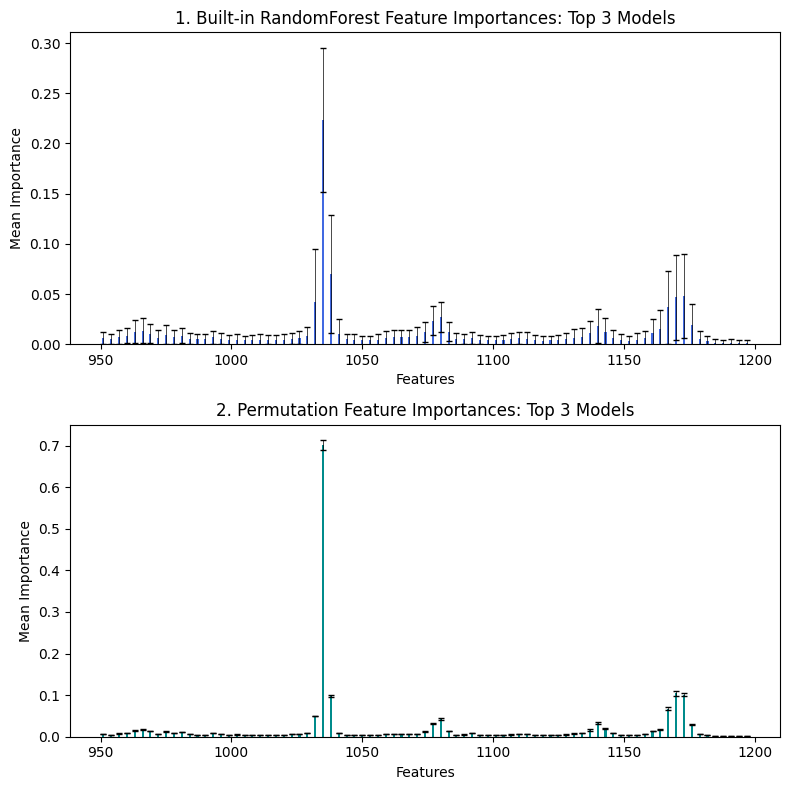

In [17]:
# Prepare data for plotting
importance_data = [
    {
        'method_name': 'Built-in RandomForest Feature Importances',
        'mean_importances': mean_feature_importances,
        'std_importances': std_feature_importances,
        'color': 'royalblue'
    },
    {
        'method_name': 'Permutation Feature Importances',
        'mean_importances': mean_permutation_importances,
        'std_importances': std_permutation_importances,
        'color': 'crimson'
    }
]

# Plot both importance methods
plot_feature_importances( importance_data,averaged_df1.columns,num_subplots=2,title_suffix=': Top 3 Models'
)

Both feature importance calculations agree that the region of 1025-1040 cm^-1 is the most important region in the spectrum for predicting glucose concentrations in solution. The two feature importance methods also agree on the top other regions, though they vary in their relative importance compared to the 1025-1040 cm^-1 region.

Initially, I will sort the wavenumbers according to their importance and use the top half of wavenumbers to retrain the model and screen the hyperparameters that were previously screened to try to improve the predictive model. This calculation is more relevant to the first task as it is an attempt to improve the existing model.

Later I will use the most important wavenumber in the spectrum and determine which width is optimal for determining glucose concentrations in free solution.







In [18]:
# Sorting the wavenumber according to their imprtance in the permutation importance calculations
np.sort(mean_permutation_importances.index[np.argsort(mean_permutation_importances)[::-1]][:41])

array([ 957.,  960.,  963.,  966.,  969.,  972.,  975.,  978.,  981.,
        993.,  996., 1026., 1029., 1032., 1035., 1038., 1041., 1059.,
       1062., 1065., 1068., 1071., 1074., 1077., 1080., 1083., 1092.,
       1110., 1113., 1131., 1134., 1137., 1140., 1143., 1146., 1161.,
       1164., 1167., 1170., 1173., 1176.])

In [19]:
# Generating a list of individual wavenumbers from the averaged_df1 wavenumbers used in the feature permutation improtance calculations
region_start = [956,992,1028,1073,1058,1109,1130,1157]
region_end = [985,994,1057,1042,1084,1111,1150,1180]

important_wavenumbers = np.array([], dtype=int)
for start,end in zip(region_start,region_end):
  important_wavenumbers = np.concatenate((important_wavenumbers,np.arange(start,end)))
print(f'Number of wavenumbers: {len(important_wavenumbers)}')


Number of wavenumbers: 131


Comparing the results of a model trained using all wavenumbers versus a model where only the most important wavenumbers are used to train the model.

In [20]:
results_df1_topWN,grid_search = train_random_forest(df1.loc[:,important_wavenumbers], y)
print(results_df1_topWN)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters: {'max_features': 'sqrt', 'min_impurity_decrease': 0.05, 'min_samples_leaf': 5, 'n_estimators': 500}
Best MARD Score: 17.37845627283556
   mean_test_score  std_test_score max_features  min_impurity_decrease  min_samples_leaf  n_estimators
0           17.378           0.781         sqrt                   0.05                 5           500
1           17.380           0.780         sqrt                   0.10                 5           500
2           17.406           0.751         sqrt                   0.05                 5           250
3           17.410           0.751         sqrt                   0.10                 5           250
4           17.476           0.809         sqrt                   0.10                10           500
5           17.476           0.809         sqrt                   0.05                10           500
6           17.480           0.806         sqrt                   0

Models trained with the most important features achieved a superior MARD score, ~17.38, compared with models trained using all features, ~17.64 .

Comment: I used half of wavenumbers as proof-of-concept, to show that training the model using only the most important wavenumbers results in a lower MARD score. Naturally, the number of features used to train the model will need to be screened and optimized according to the best MARD score achieved.

Sorting the most important features from the feature permutation calculations:

In [21]:
mean_permutation_importances.index[np.argsort(mean_permutation_importances)[::-1]][:41]

Index([1035.0, 1170.0, 1173.0, 1038.0, 1167.0, 1032.0, 1080.0, 1140.0, 1077.0, 1176.0, 1143.0, 1164.0, 966.0, 1137.0, 963.0, 969.0, 1083.0, 1161.0, 1074.0, 975.0, 981.0, 960.0, 1134.0, 1092.0, 1041.0, 978.0, 1029.0, 993.0, 1146.0, 957.0, 1131.0, 972.0, 1110.0, 1062.0, 1071.0, 1113.0, 1065.0, 1026.0, 996.0, 1068.0, 1059.0], dtype='float64')

Isolating the most important wavenumbers of each distinct region in the spectrum:

In [22]:
lasers = [1035,1170,1138,1080,966]

Generating a laser wavenumber combination matrix. Model training will use laser configurations according to the table.

Comment: Multiple lasers weren't suggested as a possible option, nevertheless I wanted to check the influence of using two distinct wavenumbers on the MARD score.


In [23]:
all_rows = []
all_rows.append(lasers)

# Iterate through the number of wavenumbers to remove (from 1 to len(numbers))
for r in range(1, len(lasers) + 1):  # Removing 1 wavenumber, 2 wavenumber, ..., up to len(wavenumber)
    for combination in combinations(range(len(lasers)), len(lasers) - r):
        # Create a row with wavenumbers aligned to their original columns
        row = [lasers[i] if i in combination else None for i in range(len(lasers))]
        all_rows.append(row)
all_rows = all_rows[:-1]
all_rows.append(all_rows[0])

# Create a DataFrame from all rows
combinations_df = pd.DataFrame(all_rows[::-1], columns=[f"laser_{i}" for i in range(len(lasers))]).iloc[:16,:]

# Display the DataFrame
print(combinations_df)

    laser_0  laser_1  laser_2  laser_3  laser_4
0    1035.0   1170.0   1138.0   1080.0    966.0
1       NaN      NaN      NaN      NaN    966.0
2       NaN      NaN      NaN   1080.0      NaN
3       NaN      NaN   1138.0      NaN      NaN
4       NaN   1170.0      NaN      NaN      NaN
5    1035.0      NaN      NaN      NaN      NaN
6       NaN      NaN      NaN   1080.0    966.0
7       NaN      NaN   1138.0      NaN    966.0
8       NaN      NaN   1138.0   1080.0      NaN
9       NaN   1170.0      NaN      NaN    966.0
10      NaN   1170.0      NaN   1080.0      NaN
11      NaN   1170.0   1138.0      NaN      NaN
12   1035.0      NaN      NaN      NaN    966.0
13   1035.0      NaN      NaN   1080.0      NaN
14   1035.0      NaN   1138.0      NaN      NaN
15   1035.0   1170.0      NaN      NaN      NaN


Each row in the table above will be used to train a model, using the best parameter combinations identified earlier, and the MARD results will be compared.

The first five rows' models compare the results of single wavenumbers (i.e. "lasers").

THe rows below compare the results when two lasers are used.

In [24]:
# Training the model accoording to different laser configurations:

laser_mean,laser_std = [],[]
for i in range(len(combinations_df)):

  model_lasers = combinations_df.loc[i, pd.notna(combinations_df.iloc[i, :])].to_list()
  best_model = RandomForestRegressor(random_state=123, **best_params)
  print(i, model_lasers)
  cv_scores = cross_val_score(best_model,df1.loc[:,model_lasers] , y, cv=cv, scoring=mard_scorer, n_jobs=-1)

  # Calculate mean and standard deviation of CV scores
  laser_mean.append(-np.mean(cv_scores))  # Negate since MARD is minimized
  laser_std.append(np.std(cv_scores))

combinations_df['MARD'] = laser_mean
combinations_df['std'] = laser_std


0 [1035.0, 1170.0, 1138.0, 1080.0, 966.0]
1 [966.0]
2 [1080.0]
3 [1138.0]
4 [1170.0]
5 [1035.0]
6 [1080.0, 966.0]
7 [1138.0, 966.0]
8 [1138.0, 1080.0]
9 [1170.0, 966.0]
10 [1170.0, 1080.0]
11 [1170.0, 1138.0]
12 [1035.0, 966.0]
13 [1035.0, 1080.0]
14 [1035.0, 1138.0]
15 [1035.0, 1170.0]


Summarizing the results visually:

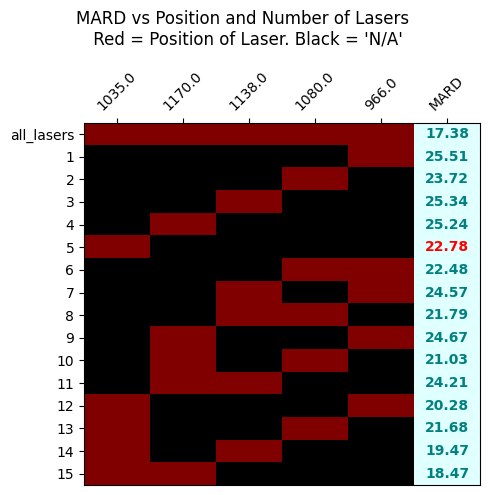

In [25]:
# Example data (replace with your actual data)
data = combinations_df.iloc[:, :-1]
data.columns = list(data.iloc[0,:-1]) +[data.columns[-1]]

# Define custom color maps
binary_cmap = ListedColormap(['black', 'maroon'])
color = matplotlib.colors.to_rgba('lightcyan')  # RGBA for pink

# Binary color matrix for the first 5 columns
binary_matrix = ~data.iloc[:, :5].isna()

# Combine both color schemes
final_colors = np.zeros((*data.shape, 4))  # RGBA matrix

# Apply binary colormap to the first 5 columns
for i in range(5):
    final_colors[:, i, :] = binary_cmap(binary_matrix.iloc[:, i])

# Apply color to the last column (index 5)
final_colors[:, 5, :] = color

# Plot
fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(final_colors, aspect='auto')

# Overlay mard values to the last column
for i in range(data.shape[0]):
    text = f"{data.iloc[i, 5]:.2f}"
    ax.text(5, i, text, ha='center', va='center', color='black', fontsize=10, fontweight='bold',
            c='teal' if combinations_df.loc[i,'MARD']!=combinations_df.loc[1:5,'MARD'].min() else 'red')

# Customize ticks and labels
ax.grid(which="minor", color="white", linestyle='-', linewidth=2)
ax.set_xticks(range(data.shape[1]))
ax.set_xticklabels(data.columns, rotation=45)
ax.xaxis.set_label_position('top')  # Place x-ticks at the top
ax.xaxis.tick_top()
ax.set_yticks(range(data.shape[0]))
ax.set_yticklabels(['all_lasers']+[f'{i}' for i in range(1,data.shape[0])])

plt.suptitle("MARD vs Position and Number of Lasers \n Red = Position of Laser. Black = 'N/A'")
plt.tight_layout()
plt.show()


Relating to the 2nd Task, the optimal laser position is at the 1035 cm^-1 wavenumber (compare the MARD scores of other 4 single laser results). This result is not surprising given the results of the feature importance calculations, and further substantiates the results so far.

Interestingly, using only these five wavenumbers together to train the model results in MARD score of 17.53, which is very close to the MARD score of 17.42 when using the top half of all wavenumbers

In addition, the results show that adding a second laser at the cm^-1 position results in a considerable decrease in MARD score. The cost-benefit of adding a second laser should be discussed.


Below is the table used to construct the figure above:

In [26]:
combinations_df

,laser_0,laser_1,laser_2,laser_3,laser_4,MARD,std
0,1035.0,1170.0,1138.0,1080.0,966.0,17.384051,0.792952
1,NaN,NaN,NaN,NaN,966.0,25.514793,1.030287
2,NaN,NaN,NaN,1080.0,NaN,23.720328,1.110801
3,NaN,NaN,1138.0,NaN,NaN,25.342629,1.341168
4,NaN,1170.0,NaN,NaN,NaN,25.236813,1.002496
5,1035.0,NaN,NaN,NaN,NaN,22.778172,1.348788
6,NaN,NaN,NaN,1080.0,966.0,22.478407,1.121540
7,NaN,NaN,1138.0,NaN,966.0,24.566316,1.208630
8,NaN,NaN,1138.0,1080.0,NaN,21.790416,1.117937
9,NaN,1170.0,NaN,NaN,966.0,24.667776,1.027364


### Determining optimal laser width
Once a laser wavenumber has been selected the effect of laser width will be determined for optimal configuration, as evident by its effect on MARD score of respective models.

In [27]:
def MARD_vs_laser_width(laser,width_start,width_end,width_increment,df1,y):
  """
  Evaluates model performance (MARD) across different laser widths using cross-validation.

  Parameters:
  laser: Center wavelength (cm^-1)
  width_start: Initial laser width
  width_end: Final laser width
  width_increment: Width increment step
  df1: Spectral data DataFrame
  y: Target values

  Returns:
  tuple: (laser_means, laser_stds, laser_widths) - Arrays of MARD means,
  standard deviations, and corresponding laser widths
  """

  laser_means,laser_stds = [],[]

  laser_widths = np.linspace(width_start,width_end,int((width_end-width_start)/width_increment+1))
  cv = KFold(n_splits=5, shuffle=True, random_state=123)
  print(f"Laser: {laser} [cm^-1]")
  for i,lw in enumerate(laser_widths):

    df_laser = df1.loc[:, (df1.columns >= laser - lw) & (df1.columns <= laser + lw)]
    best_model = RandomForestRegressor(random_state=123, **best_params)

    cv_scores = cross_val_score(best_model, df_laser , y, cv=cv, scoring=mard_scorer, n_jobs=-1)

    # Calculate mean and standard deviation of CV scores
    laser_means.append(-np.mean(cv_scores))  # Negate since MARD is minimized
    laser_stds.append(np.std(cv_scores))
    print(f"laser width: {lw}, mean MARD: {round(laser_means[-1],3)}")

  return np.array(laser_means),np.array(laser_stds),laser_widths

In [28]:
def calculate_t_test(mean1, std1, mean2, std2, n1, n2, alpha=0.05):
    """
    Perform independent t-test given means, standard deviations, and sample sizes.

    Parameters:
    mean1, mean2: Means of the two groups
    std1, std2: Standard deviations of the two groups
    n1, n2: Sample sizes
    alpha: Significance level (default 0.05)

    Returns:
    tuple: (t_statistic, p_value, is_significant)
    """
    # Calculate pooled standard error
    se = np.sqrt((std1**2/n1) + (std2**2/n2))

    # Calculate t-statistic
    t_stat = (mean1 - mean2) / se

    # Calculate degrees of freedom (Welch's approximation)
    numerator = (std1**2/n1 + std2**2/n2)**2
    denominator = (std1**4/(n1**2*(n1-1)) + std2**4/(n2**2*(n2-1)))
    df = numerator/denominator

    # Calculate two-tailed p-value
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df))

    # Determine if difference is significant
    is_significant = p_value < alpha

    return t_stat, p_value, is_significant

In [29]:
def laser_width_significance_vs_original_wavenumber(laser_means,laser_stds,cv):
  """
  Calculates statistical significance and relative improvement of laser widths relative to the original wavelength.

  Parameters:
  laser_means: Array of mean MARD values
  laser_stds: Array of MARD standard deviations
  cv: Cross-validation splitter object

  Returns:
  tuple: (significance, mean_improvement, std_mean_improvement)
      - significance: List of boolean values indicating significant differences
      - mean_improvement: Percentage improvement from initial width
      - std_mean_improvement: Standard deviation of improvements
  """

  mean_improvement = 100*(laser_means[0]-laser_means)/laser_means[0]
  std_mean_improvement = 100*np.sqrt((laser_means**2 / laser_means[0]**4) * laser_stds[0]**2 + (1 /  laser_means[0]**2) * laser_stds**2)

  n1 = n2 = cv.n_splits # Sample sizes
  mean1 = laser_means[0]
  mean2 = laser_means[1:]
  std1 = laser_stds[0]
  std2 = laser_stds[1:]

  p_values = []
  for m2,s2 in zip(mean2,std2):
    t_stat, p_value, is_significant = calculate_t_test(mean1, std1, m2, s2, n1, n2)
    p_values.append(p_value)

  return p_values,mean_improvement,std_mean_improvement

In [76]:
def laser_width_significance_all_combinations(means,stds,cv):
  """
  Calculates statistical significance and relative improvement between laser widths between all possible laser width combinations.

  Parameters:
  laser_means: Array of mean MARD values
  laser_stds: Array of MARD standard deviations
  cv: Cross-validation splitter object

  Returns:
  tuple: (significance, mean_improvement, std_mean_improvement)
      - significance: List of boolean values indicating significant differences
      - mean_improvement: Percentage improvement from initial width
      - std_mean_improvement: Standard deviation of improvements
  """

  n1 = n2 = cv.n_splits # Sample sizes

  p_values,mean_improvement,std_mean_improvement = np.ones((len(means),len(means))),np.zeros((len(means),len(means))),np.zeros((len(means),len(means)))
  for i in range(len(means)-1):
    for j in range(i+1,len(means)):
      mean_improvement[i,j] =100*(means[i]-means[j])/means[i]
      std_mean_improvement[i,j] =100*np.sqrt((means[j]**2 / means[i]**4) * stds[i]**2 + (1 /  stds[i]**2) * stds[j]**2)
      _, p_values[i,j] , _ = calculate_t_test(means[i], stds[i], means[j], stds[j], n1, n2)


  return p_values,mean_improvement,std_mean_improvement

In [31]:
def plot_laser_widths_MARD_vs_original_wavenumber(p_values,mean_improvement,std_improvement,laser_widths):
  """
  Creates an error bar plot comparing laser width vs original wavenumber, improvements with significance markers.

  Parameters:
  significance: List of boolean values indicating statistical significance
  mean_improvement: Array of percentage improvements in MARD
  std_mean_improvement: Array of standard deviations for improvements
  laser_widths: Array of laser width values

  Returns:
  None: Displays a matplotlib figure with error bars and significance markers
  """

  # Plot mean_improvement with error bars
  plt.figure(figsize=(8, 4))
  plt.errorbar(laser_widths, mean_improvement, yerr=std_improvement, fmt='D', capsize=3, label='Mean Improvement',color='midnightblue',ecolor='black',elinewidth=1)
  plt.axhline(0, color='gray', linestyle='--', linewidth=0.8, label='No Improvement')

  for i, (x_axis, y_axis, p_val) in enumerate(zip(laser_widths[1:len(p_values)+1], mean_improvement[1:len(p_values)+1], p_values)):
    if p_val<0.05 and p_val>0.01:  # Ensure significant values are marked
        plt.text(
            x_axis,
            y_axis + std_improvement[i+1] + 0.04,  # Position above the error bar
            '*',  # Asterisk for significant values
            fontsize=18,
            color='firebrick',
            ha='center'
        )
    if p_val<0.01:  # Ensure significant values are marked
        plt.text(
            x_axis,
            y_axis + std_improvement[i+1] + 0.04,  # Position above the error bar
            '**',  # Double asterisk for highly significant values
            fontsize=18,
            color='red',
            ha='center'
        )

  plt.suptitle('Mean Improvement vs Width of 1035 [cm^-1] Laser', fontsize=14)
  plt.xlabel('Laser Width (+-wavenumber from 1035) [cm^-1]', fontsize=12)
  plt.ylabel('Mean Improvement %', fontsize=12)
  plt.legend(fontsize=12)
  plt.grid(alpha=0.5)
  plt.tight_layout()
  plt.show()
  return

In [72]:
def plot_laser_widths_MARD_all_combinations(p_values,mean_improvement,laser_widths):

  """
  Creates an error bar plot comparing laser width all combinations, improvements with significance markers.

  Parameters:
  significance: List of boolean values indicating statistical significance
  mean_improvement: Array of percentage improvements in MARD
  std_mean_improvement: Array of standard deviations for improvements
  laser_widths: Array of laser width values

  Returns:
  None: Displays a matplotlib figure with error bars and significance markers
  """


  fig, axes = plt.subplots(1, 2, figsize=(14, 6))
  titles = ['Mean Improvement %', '-log(p_value)']
  datas = [mean_improvement, -np.log10(p_values)]
  for i, ax in enumerate(axes):
    im = axes[i].imshow(datas[i], origin='lower', cmap='cividis', aspect='auto')
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Laser Width A')
    axes[i].set_ylabel('Laser Width B')

    num_ticks = len(laser_widths)
    axes[i].set_xticks(np.arange(num_ticks))
    axes[i].set_yticks(np.arange(num_ticks))
    axes[i].set_xticklabels(np.round(laser_widths, 2))
    axes[i].set_yticklabels(np.round(laser_widths, 2))
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].invert_yaxis()

    fig.colorbar(im, ax=axes[i], label=titles[i])

  fig.suptitle('Comparisson of all wavenumber ranges combinations to determine optimal range')
  plt.tight_layout()
  plt.show()

  return

Initial screen using broad increments of 5 [cm^-1] wavenumbers for each training iteration:

Laser: 1035.0 [cm^-1]
laser width: 0.0, mean MARD: 22.778
laser width: 7.5, mean MARD: 20.167
laser width: 15.0, mean MARD: 20.297
laser width: 22.5, mean MARD: 20.441
laser width: 30.0, mean MARD: 20.421
laser width: 37.5, mean MARD: 20.498
laser width: 45.0, mean MARD: 20.494
laser width: 52.5, mean MARD: 19.899
laser width: 60.0, mean MARD: 19.372
laser width: 67.5, mean MARD: 19.233
laser width: 75.0, mean MARD: 19.148


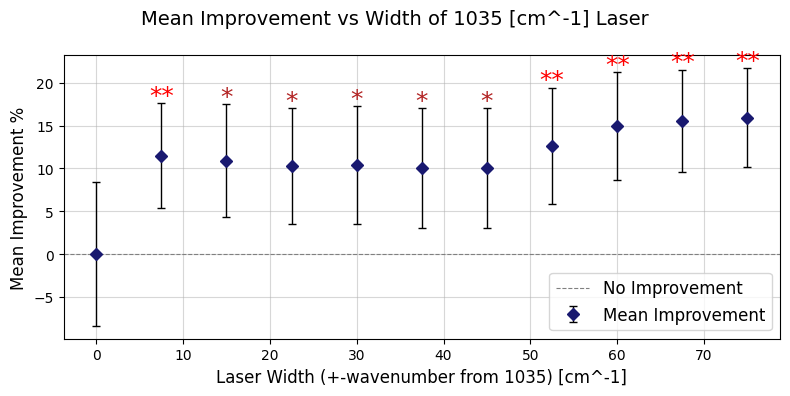

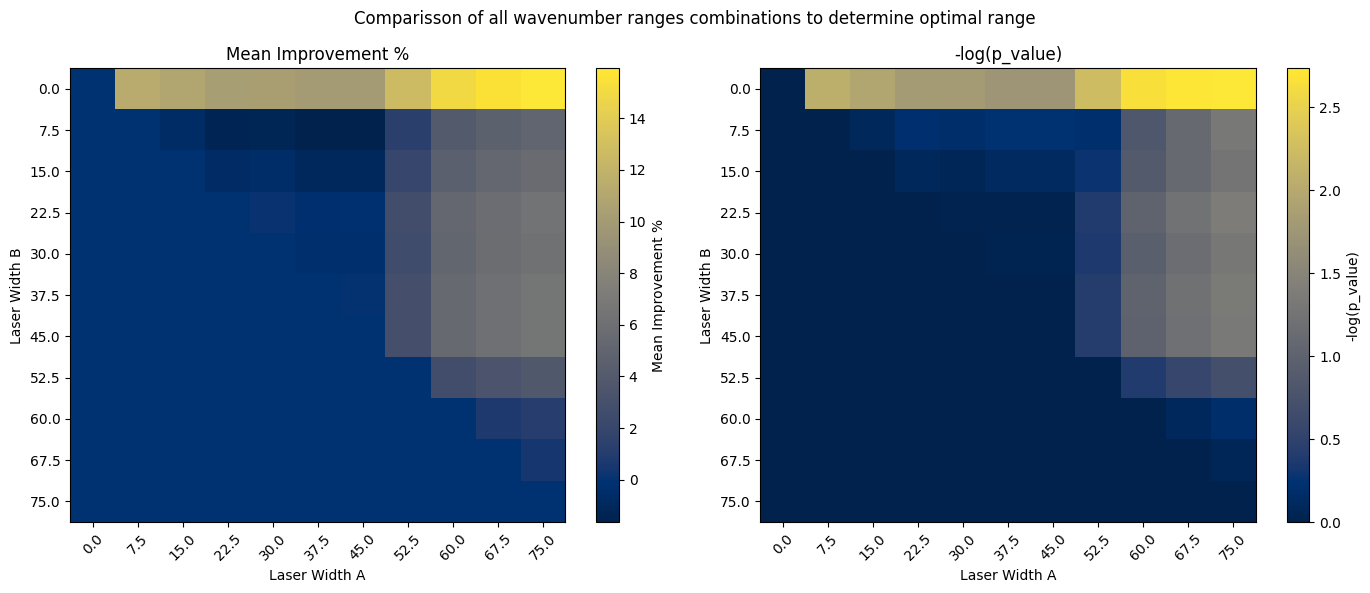

In [77]:
laser=  1035.0
width_start= 0
width_end= 75
width_increment=  7.5

laser_means,laser_stds,laser_widths = MARD_vs_laser_width(laser,width_start,width_end,width_increment,df1,y)
p_values,mean_improvement,std_improvement = laser_width_significance_vs_original_wavenumber(laser_means,laser_stds,cv)
plot_laser_widths_MARD_vs_original_wavenumber(p_values,mean_improvement,std_improvement,laser_widths)
p_values,mean_improvement,std_improvement = laser_width_significance_all_combinations(laser_means,laser_stds,cv)
plot_laser_widths_MARD_all_combinations(p_values,mean_improvement,laser_widths)

In [58]:
laser_widths


array([ 0. ,  7.5, 15. , 22.5, 30. , 37.5, 45. , 52.5, 60. , 67.5, 75. ])

The results show that at a width of plus/minus 10 [cm^-1] the 1035 laser has a significant mean increase in MARD scoring compared to the 1-wide 1035 laser. Further increasing the laser width results in a significant increase of MARD, however this increase is lower than that of the plus/minus 7.5-15 [cm-1]. At ~plus/minus 45 [cm^-1] the MARD starts increasing again, however such a wide laser is presumably more expensive than the marginal increase in model results. Higher resolution increments at the 1-15 [cm-1] range will next be evaluated.

Now that I have the region of laser width where models produce better results, a more nuanced screening in higher resultion can be preformed:

Laser: 1035.0 [cm^-1]
laser width: 0.0, mean MARD: 22.778
laser width: 1.0, mean MARD: 22.002
laser width: 2.0, mean MARD: 21.706
laser width: 3.0, mean MARD: 21.205
laser width: 4.0, mean MARD: 20.689
laser width: 5.0, mean MARD: 20.492
laser width: 6.0, mean MARD: 20.323
laser width: 7.0, mean MARD: 20.167
laser width: 8.0, mean MARD: 20.078
laser width: 9.0, mean MARD: 20.099
laser width: 10.0, mean MARD: 20.078
laser width: 11.0, mean MARD: 20.149
laser width: 12.0, mean MARD: 20.199
laser width: 13.0, mean MARD: 20.212
laser width: 14.0, mean MARD: 20.286
laser width: 15.0, mean MARD: 20.297


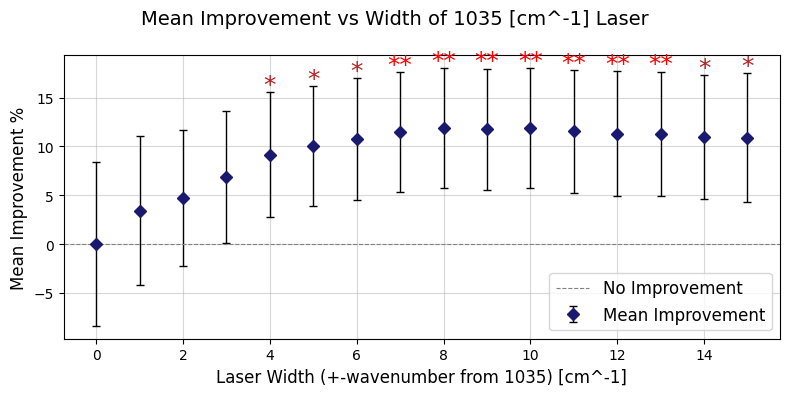

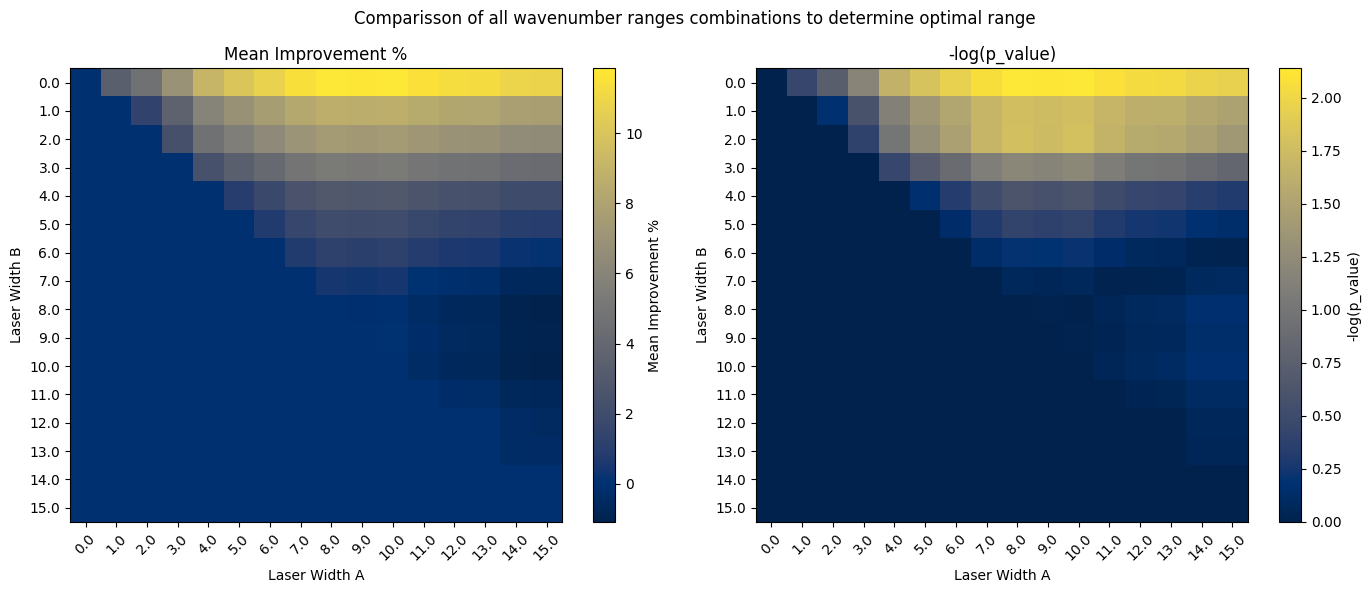

In [78]:
laser=  1035.0
width_start= 0
width_end= 15
width_increment=  1

laser_means,laser_stds,laser_widths = MARD_vs_laser_width(laser,width_start,width_end,width_increment,df1,y)
significance,mean_improvement,std_improvement = laser_width_significance_vs_original_wavenumber(laser_means,laser_stds,cv)
plot_laser_widths_MARD_vs_original_wavenumber(significance,mean_improvement,std_improvement,laser_widths)
p_values,mean_improvement,std_improvement = laser_width_significance_all_combinations(laser_means,laser_stds,cv)
plot_laser_widths_MARD_all_combinations(p_values,mean_improvement,laser_widths)

Results show that starting from a width of plus/minus 4 the MARD improvement is significant. Moreover, the MARD gradually improves (=decrease) up to plus/minus 10 and then starts increasing.


The tradeoff between model improvement and laser width depends on the cost of increasing the width versus the fpotential inancial improvement\ of MARD decrease achieved. As this relationship is unknown to me, I cannot say exactly which laser is most beneficial in this context. I can conclude that a range of plus/minus 4-10 produces a significant improvement over the single-wavenumber laser, with 10 providing the largest improvement in MARD score. Given no other information I would recommend using a +-10 width.


### Task 3: Phantom Glucose Concetrations



In [61]:
df2 = pd.read_json('/content/drive/MyDrive/glucose/dataset_2.json')

In [62]:
df2.sort_values(by='glucose',inplace=True)
df2.reset_index(drop=True,inplace=True)
glucose_df2 = df2['glucose']

In [63]:
df2 = pd.DataFrame(
    df2["absorbance"].to_list(),
    columns=df2["wavenumber"][0]  # Use the first row of wavenumbers as columns
)


In [64]:
def plot_phantom_subplot(ax, df, glucose, title, zlabel, title_fontsize=14):
    """
    Creates a 3D scatter plot of spectral data with colored points by glucose concentration.

    Parameters:
    ax: Matplotlib 3D axis object
    df: DataFrame containing spectral data
    glucose: Array of glucose concentration values
    title: Plot title string
    zlabel: Label for z-axis
    title_fontsize: Font size for plot title (default: 14)

    Returns:
    None: Updates the provided axis with 3D scatter plot
    """

    cmap = matplotlib.colormaps.get_cmap('magma')
    colors = [cmap(i / len(df)) for i in range(len(df))]

    x_axis = df.columns.astype(float)  # Convert to numeric if they're strings

    # Iterate through the DataFrame properly
    for i, (idx, row) in enumerate(df.iterrows()):
        y_axis = [i] * len(x_axis)
        z_axis = row.values  # Get the values directly from the row
        ax.scatter(x_axis, y_axis, z_axis, label=f"{glucose[i]}", c=[colors[i]])

    ax.set_title(title, fontsize=title_fontsize)
    ax.set_xlabel("Wavenumber [cm^-1]", fontsize=12)
    ax.set_ylabel("Sample #", fontsize=12)
    ax.set_yticks(range(len(df)))
    ax.set_zlabel(zlabel, fontsize=12)
    ax.legend(title="Glucose Conc.", fontsize=10, title_fontsize=8)
    return

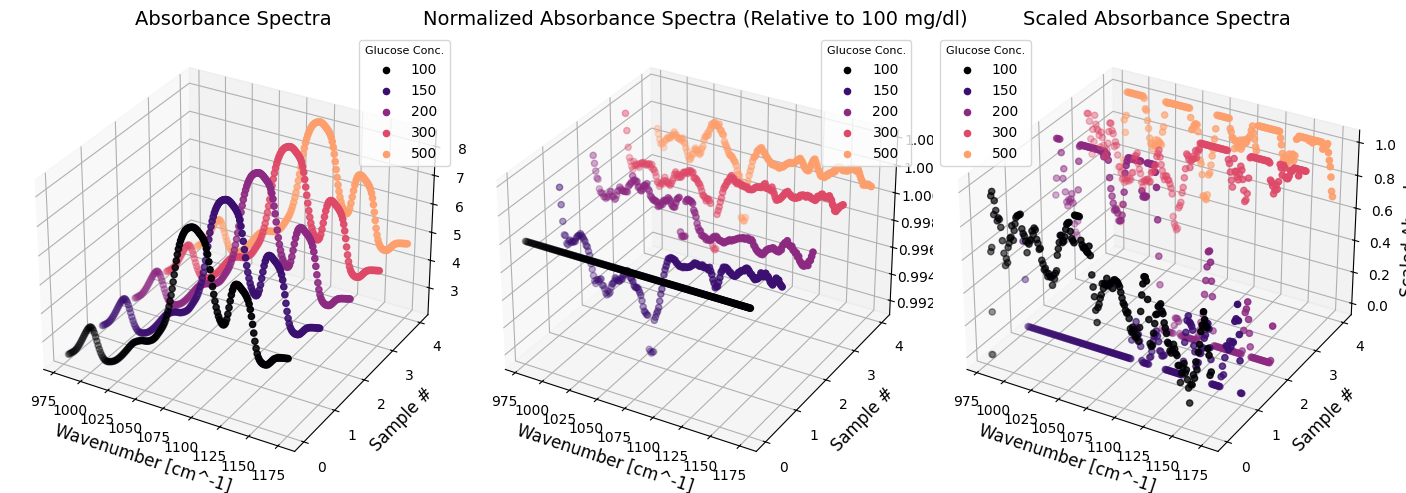

In [65]:
# Create plots according to different absorbance transformations

fig, axes = plt.subplots(1, 3, figsize=(14, 6), subplot_kw={'projection': '3d'})

plot_phantom_subplot(axes[0], df2, glucose_df2, "Absorbance Spectra","Absorbance",title_fontsize=14)
plot_phantom_subplot(axes[1], df2/df2.iloc[0,:], glucose_df2, "Normalized Absorbance Spectra (Relative to 100 mg/dl)","Normalized Absorbance",title_fontsize=14)
sf2_scaler = MinMaxScaler()
df2_scaled = pd.DataFrame(sf2_scaler.fit_transform(df2), columns=df2.columns)
plot_phantom_subplot(axes[2], df2_scaled, glucose_df2, "Scaled Absorbance Spectra", "Scaled Absorbance",title_fontsize=14)

plt.tight_layout()
plt.show()


The absorbance spectra on the left looks similar across all glucose concentrations. Likely the variations in absorbance are small.
In the middle plot the absorbance is normalized relative to the lowest concentration - 100[mg/dl]. The variation in absorbance is indeed small and fluctuates in the +-1% region of absorbance measurements.

The right plot shows the absorbance after scaling using MinMaxScaler. Potentially these variations can be used to predict glucose concentrations if some of these fluctuations are the result of true signal associated with glucose concentrations, and not due to measurement noise associated with the system, such as the phantom themselves or temperature.

Regarding the question whether the device is capable of capturing glucose information, the answer is potentially yes. 1% fluctuations could represent actual glucose-associated signals. However assessing signal-to-noise in these absorption variations will require many repetitions for the model to make significant predictions.

#### (Attempting) prediction of phantom glucose concentrations:
Ideally a model trained on phantom glucose concentrations should b
e used to predict phantom test concentrations. This is probably very expensive to achieve. Alternatively, using transfer learning (using neural networks architecture for example), a model could be trained initially in free solution and a small phantom training set could be later used to direct the network towards the more desired conditions.

I will attempt to use the previous models constructed in this analysis to predict the phantom glucose concentrations, however:
1. As stated above, the models were trained on solution absorbance and will likely underfit when such a major change in the system is introduced (i.e. free solution vs phantoms).
2. The free solution models were not trained to evaluate concentrations above 195 [mg/dl] and will not be able to accurately predict concentrations in these regions.

Nevertheless, three models will be used to predict the phantom glucose concentrations, under the understanding that the results will probably not be accurate (in the best case), or will reflect random noise (in the worst case):
1. A model trained using the free solution dataset, using all the wavenumbers available in the phantom dataset (the phantom absorbance spectra are narrower).
2. A model trained using the free solution dataset, using only the most important wavenumber that were identified in the feature permutation calculations (the top half of wavenumbers) that are available in the phantom absorbance spectrum.
3. A model trained using the free solution dataset, using only the 1035 [cm^-1] laser with a width of +-10 wavenumbers.

All models will be trained using the best hyperparameters identified earlier.





In [66]:
model_names= ['all_features','top_half','single_laser_wide']
laser = 1035.0
lw = 10       # = laser width
phantom_important_wavenumbers = [wavenumbers for wavenumbers in important_wavenumbers if wavenumbers in df2.columns]
features_used = [df2.columns,phantom_important_wavenumbers,df2.columns[(df2.columns >= laser - lw) & (df2.columns <= laser + lw)]]
print(f'phantom glucose concetrations: {list(glucose_df2)}')

for name,features in zip(model_names,features_used):

  print('\n',name)
  df = df1.loc[:,features]
  model = RandomForestRegressor(random_state=123, **best_params)
  model.fit(df,y)
  yhat = model.predict(pd.DataFrame(sf2_scaler.transform(df2), columns=df2.columns).loc[:,features])
  print(f'predicted glucose concetrations: {yhat}')
  print(f'MARD of prediction: {round(mard(list(glucose_df2),yhat),3)}')

phantom glucose concetrations: [100, 150, 200, 300, 500]

 all_features
predicted glucose concetrations: [160.64322913  92.78412177 165.38245699 161.07494302 173.93273113]
MARD of prediction: 45.524

 top_half
predicted glucose concetrations: [163.02358583  90.49176193 169.72455771 158.46788025 174.2382376 ]
MARD of prediction: 46.033

 single_laser_wide
predicted glucose concetrations: [140.21372177  92.71877623 157.48730336 152.52924733 179.08531413]
MARD of prediction: 42.599


As expected, all three predictions produce a very high MARD score. The concentrations predicted do not increase with the actual increase in glucose concentrations, suggesting that the results are more due to noise than actual signal. As expected, the 300 and 500 [mg/dl] concentrations fall below 200 [mg/dl] as the model can't predict values above 195 [mg/dl].


In [67]:
time.time() - start_time

2563.998379945755